보간하는 방법 사용

### 경로 데이터 불러오기 / 보간

In [57]:
import os
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

filenames = []
# CSV 파일에서 경로 데이터를 추출하는 함수
def extract_lat_lng_from_csv(directory):
    all_lat_lng_lists = []
    file_count = 0
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            filenames.append(filename)
            filepath = os.path.join(directory, filename)
            df = pd.read_csv(filepath)
            lat_lng_list = [(row['lat'], row['lng']) for index, row in df.iterrows()]
            all_lat_lng_lists.append(lat_lng_list)
    return all_lat_lng_lists
 
# 경로 데이터를 보간하여 동일한 길이로 만드는 함수
def interpolate_path(path, num_points=10):
    latitudes = [point[0] for point in path]
    longitudes = [point[1] for point in path]
    distances = np.linspace(0, 1, len(path))
    interp_lat = interp1d(distances, latitudes, kind='linear')
    interp_lon = interp1d(distances, longitudes, kind='linear')
    new_distances = np.linspace(0, 1, num_points)
    new_latitudes = interp_lat(new_distances)
    new_longitudes = interp_lon(new_distances)
    return np.column_stack((new_latitudes, new_longitudes)).flatten()
 
# 경로 데이터를 읽어오는 경로 설정
directory_path = "../어디쉐어/어디쉐어 dbscan_interpolate"
lat_lng_values = extract_lat_lng_from_csv(directory_path)
 
# 보간된 경로 벡터들
path_vectors = np.array([interpolate_path(path) for path in lat_lng_values])
print('path_vectors'),path_vectors

path_vectors


(None,
 array([[ 37.537137  , 126.649466  ,  37.53705567, ..., 126.648871  ,
          37.53784   , 126.648342  ],
        [ 37.5336    , 126.653452  ,  37.53392489, ..., 126.653194  ,
          37.535062  , 126.653194  ],
        [ 37.53191   , 126.647907  ,  37.531899  , ..., 126.646855  ,
          37.531881  , 126.646855  ],
        ...,
        [ 37.644554  , 127.680359  ,  37.644554  , ..., 127.680359  ,
          37.644554  , 127.680359  ],
        [ 37.685359  , 127.530572  ,  37.65593678, ..., 127.000507  ,
          37.511416  , 127.000507  ],
        [ 37.538301  , 126.646906  ,  37.53831322, ..., 126.646967  ,
          37.538356  , 126.646967  ]]))

### 최적 파라미터

threshold 0.0077715186008398066
[0.08409537 0.08549764 0.09507086 0.09793757 0.10344925 0.12658801
 0.12678406 0.1350862  0.13980116 0.14854765 0.15015042 0.17654828
 0.18085791 0.19831549 0.19831549 0.20866819 0.21029788 0.23244072
 0.23431841 0.25985672 0.26196834 0.26455087 0.26860032 0.26926609
 0.26926609 0.31560867 0.33408949 0.33498265 0.34404919 0.36155937
 0.36672701 0.36752061 0.36890954 0.40014692 0.4039572  0.4983122
 0.64008605 0.6926267  0.84142836 0.85804535 0.8588943  0.91581138
 0.92218125 0.92301392 0.92971358 0.94150326 0.94150326 0.95920698
 0.96340467 1.01217836 1.02553196 1.04450271 1.14344205 1.14344205
 1.41075853 2.52727186 6.03138974 6.06738043]
eps_opt:0.3528042783205546


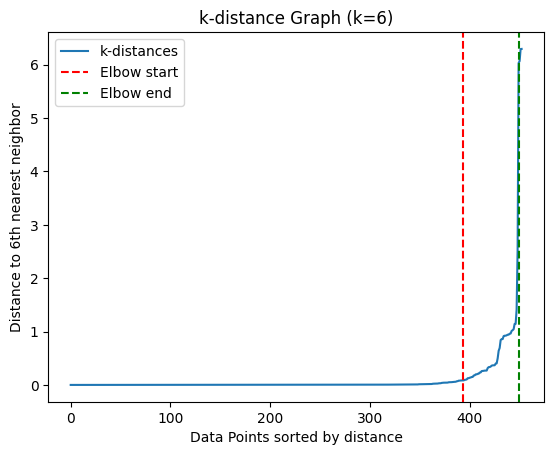

In [66]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import statistics


# k 값을 설정 (예: 4)
k = 6

# NearestNeighbors 모델을 사용하여 이웃 계산
neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(path_vectors)

# 각 데이터 포인트의 k번째 이웃까지의 거리 계산
distances, indices = neigh.kneighbors(path_vectors)

# k번째 이웃까지의 거리만 추출 (k번째 이웃의 거리를 사용)
k_distances = distances[:, -1]

# k-거리를 오름차순으로 정렬
k_distances = np.sort(k_distances)

# k-거리의 차이 계산 (기울기)
gradients = np.diff(k_distances)

# 기울기의 변화량 계산
gradients_diff = np.diff(gradients)

# 급격한 변화가 발생하는 인덱스 찾기 (최초의 큰 변화 찾기)
threshold = np.percentile(gradients_diff, 95)  # 기울기 변화 중 상위 5%를 임계값으로 설정
print('threshold',threshold)
elbow_start = np.argmax(gradients_diff > threshold)  # 첫 번째 급격한 변화 지점
elbow_end = len(gradients_diff) - np.argmax(np.flip(gradients_diff) > threshold) - 1  # 마지막 급격한 변화 지점

# y-좌표 값 출력 (k-거리)
y_values = k_distances[elbow_start:elbow_end + 2]
print(y_values)
eps_opt=statistics.median(y_values) # 중앙값으로 결정
print(f"eps_opt:{eps_opt}")


# k-거리 그래프 시각화
plt.plot(k_distances, label='k-distances')
plt.axvline(x=elbow_start, color='r', linestyle='--', label='Elbow start')
plt.axvline(x=elbow_end, color='g', linestyle='--', label='Elbow end')
plt.xlabel("Data Points sorted by distance")
plt.ylabel(f"Distance to {k}th nearest neighbor")
plt.title(f"k-distance Graph (k={k})")
plt.legend()
plt.show()


### 경로 데이터 시각화 (입력 데이터)

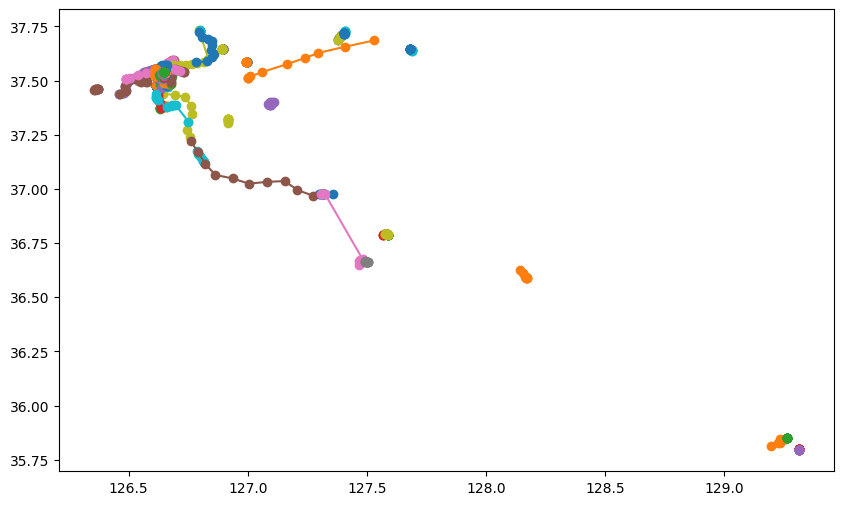

In [59]:
# 경로 벡터 시각화
plt.figure(figsize=(10, 6))

for i, path in enumerate(path_vectors):
    latitudes = path[::2]  # 짝수 인덱스는 위도
    longitudes = path[1::2]  # 홀수 인덱스는 경도
    plt.plot(longitudes, latitudes, marker='o', label=f'Path {i+1}')

### DBSCAN 모델로 이상치 판단 및 시각화 (출력 데이터)

eps : 0.4001469198632445
min_samples : 6
정상 data 개수 : 429
비정상 data 개수 : 24


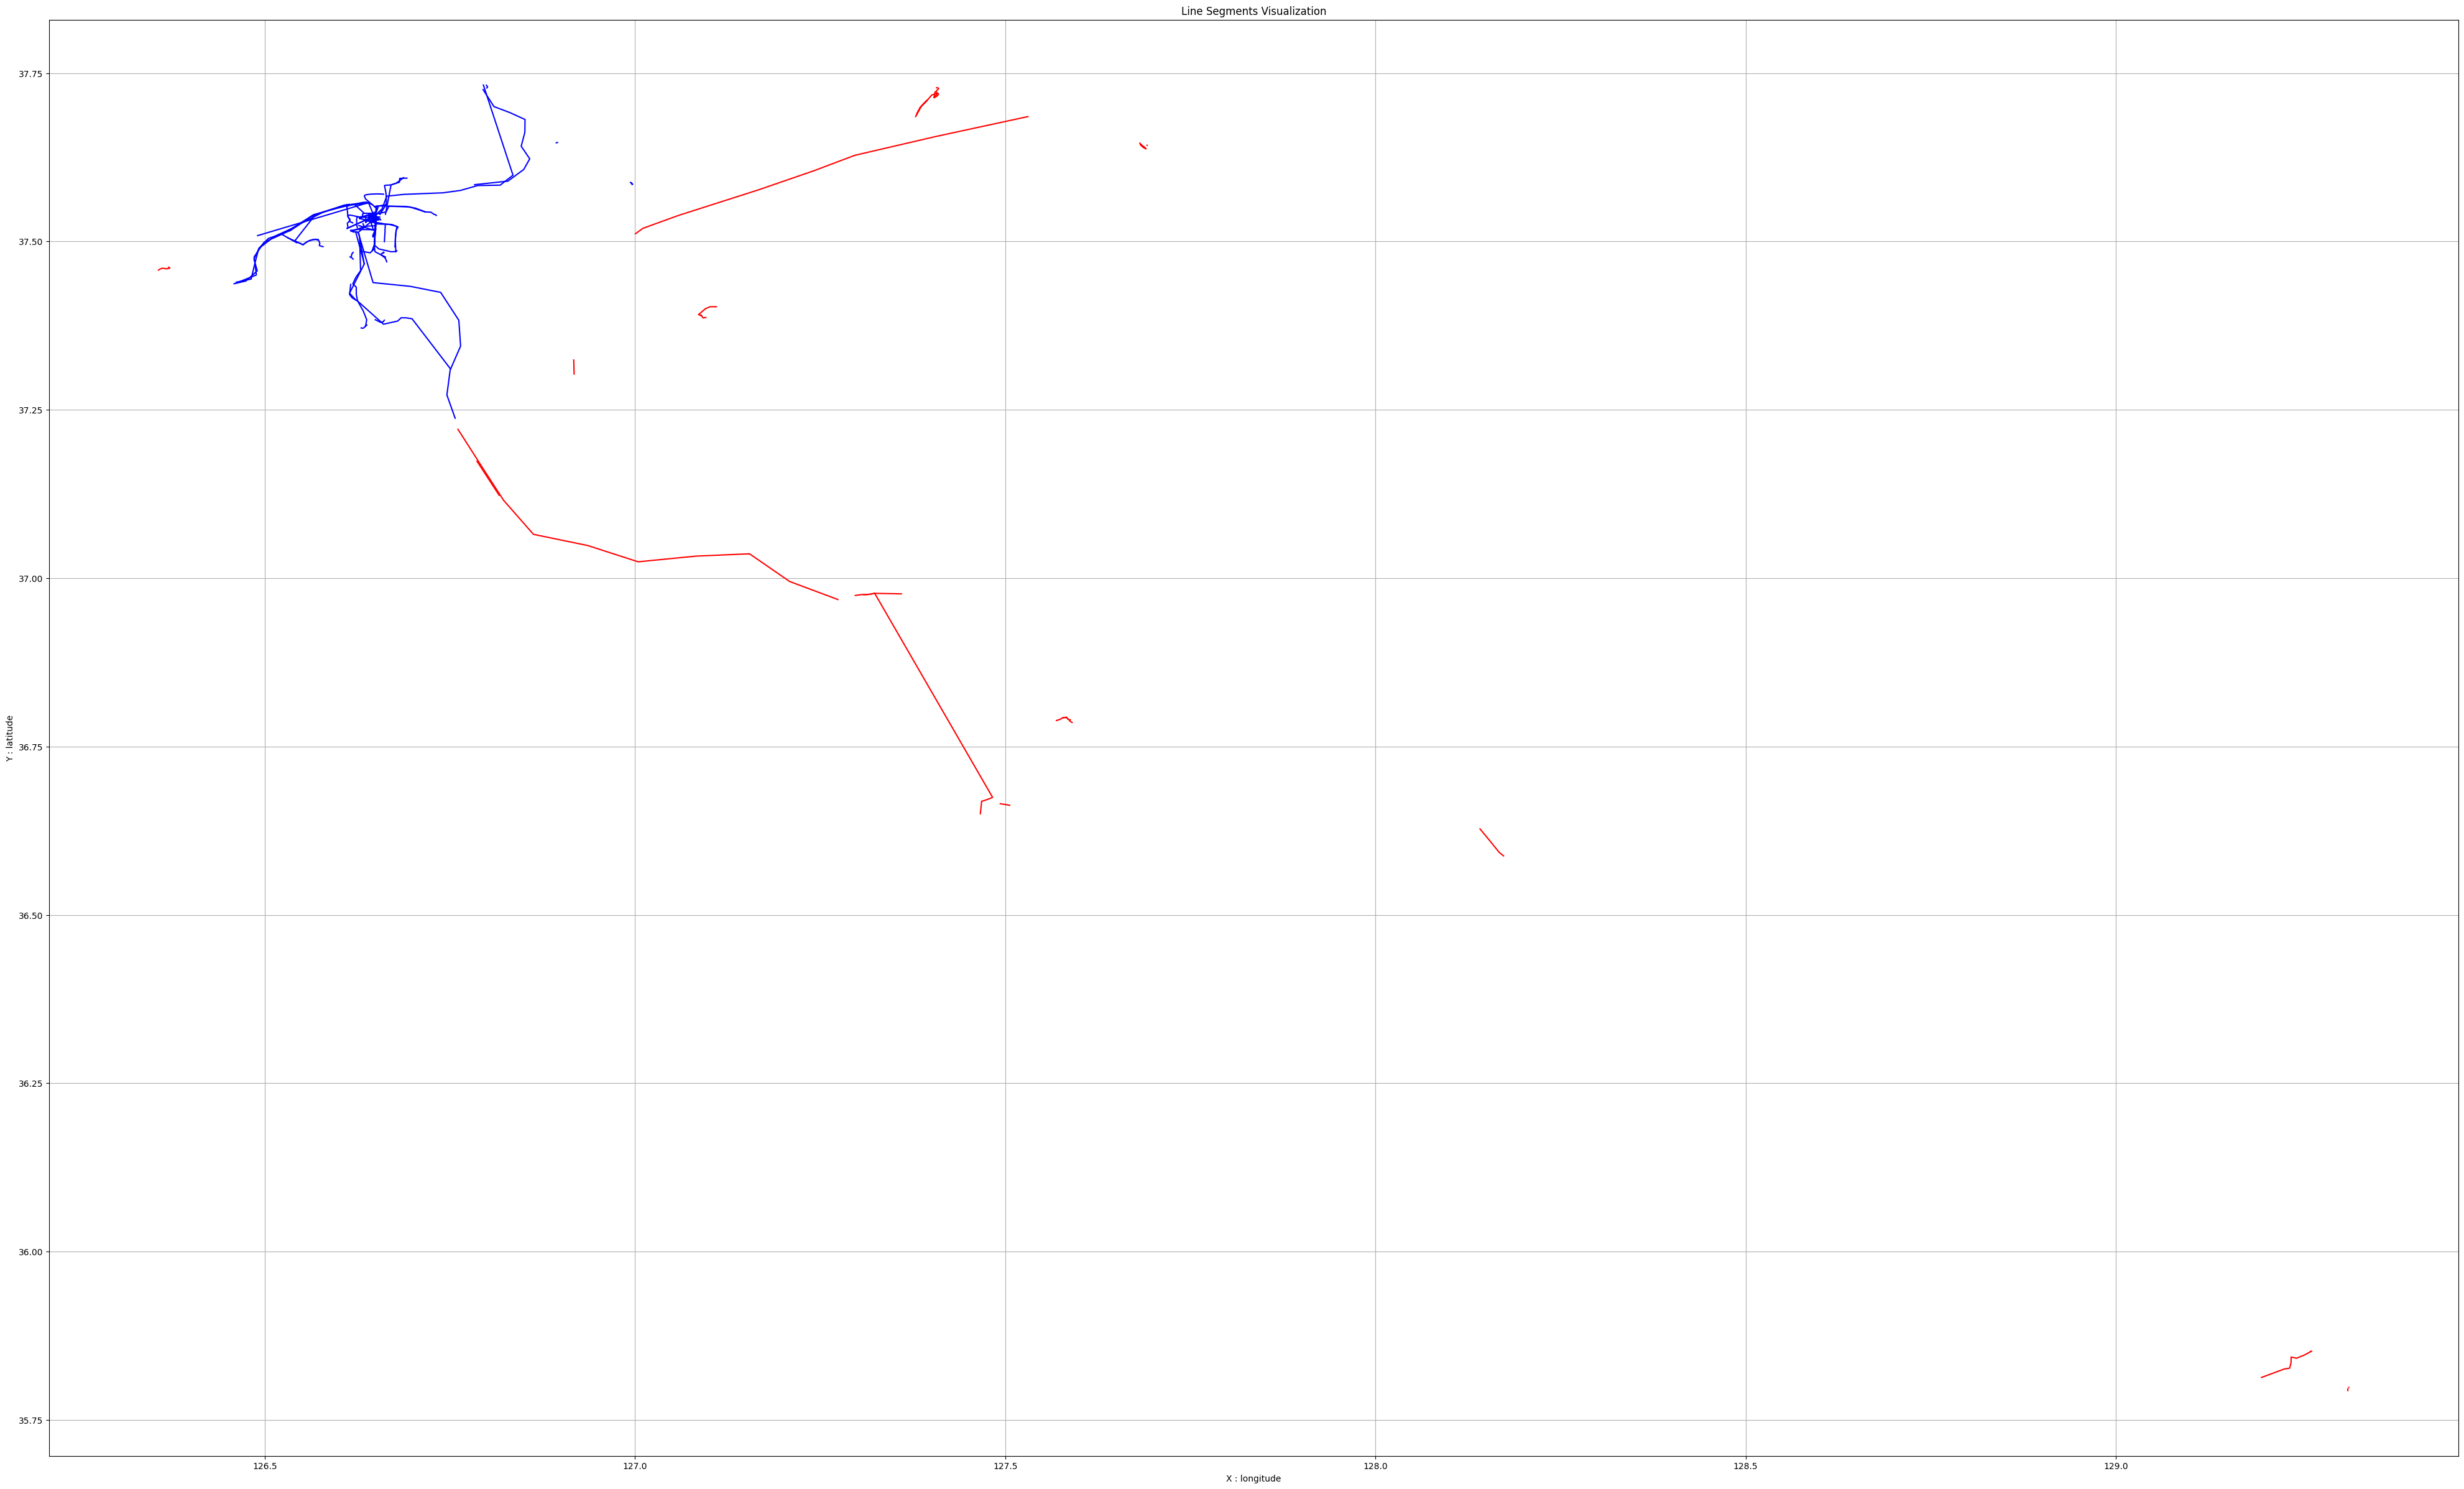

In [60]:
dbscan = DBSCAN(eps=eps_opt, min_samples=k)
labels = dbscan.fit_predict(path_vectors)

print(f"eps : {eps_opt}")
print(f"min_samples : {k}")
print(f"정상 data 개수 : {sum(labels!=-1)}")
print(f"비정상 data 개수 : {sum(labels==-1)}")


plt.figure(figsize=(50, 30))
# 시각화
for segment, label in zip(path_vectors, labels):
    x_coords = segment[1::2]
    y_coords = segment[0::2]
    color = 'red' if label == -1 else 'blue'
    plt.plot(x_coords, y_coords, color=color)

plt.title('Line Segments Visualization')
plt.xlabel('X : longitude')
plt.ylabel('Y : latitude')
plt.grid(True)
plt.show()

### 이상치 여부를 원본 CSV 파일에 기록

In [61]:
# 이상치 여부를 'dbscan output' 열에 기록하는 함수

def record_outliers(directory, labels, filenames):
 
    for label, filename in zip(labels, filenames):
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        if label == -1:
            df['output'] = 'AN'  # 기본값 1로 설정
        else:
            df['output'] = 'N'  # 이상치일 경우 -1로 설정
        df.to_csv(filepath, index=False)

# 이상치 여부를 CSV 파일에 기록
record_outliers(directory_path, labels, filenames)


### DBSCAN 이상경로 파일명 출력

In [65]:
# 이상경로 파일명을 텍스트로 출력하는 함수
def print_outlier_paths_with_filenames(labels, filenames):
    print('--------outlier_paths--------')
    for label, filename in zip(labels, filenames):
        if label == -1:
            print(f"{filenames.index(filename)} | {filename}")

# 이상경로 파일명을 텍스트로 출력
outlier_paths = print_outlier_paths_with_filenames(labels, filenames)


--------outlier_paths--------
39 | 20230429084545.csv
40 | 20230430160248.csv
41 | 20230430184009.csv
42 | 20230430190656.csv
43 | 20230430220837.csv
215 | 20230715132948.csv
216 | 20230715154101.csv
217 | 20230715194033.csv
218 | 20230716140812.csv
257 | 20230812122439.csv
258 | 20230812125121.csv
259 | 20230813201825.csv
260 | 20230814113500.csv
288 | 20230829192601.csv
304 | 20230910105144.csv
331 | 20231001111709.csv
332 | 20231001150901.csv
333 | 20231002105108.csv
334 | 20231003181802.csv
375 | 20231021173304.csv
448 | 20231202151537.csv
449 | 20231202171651.csv
450 | 20231202211845.csv
451 | 20231202230952.csv
